In [1]:
# https://docs.snowflake.com/en/user-guide/python-connector-api.html
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import time
import re

import contractions
import unidecode
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
import spacy
import en_core_web_sm
import re

# Don't collapse Pandas Dataframes:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

# Set Global Float for Rounding
pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
df = pd.read_csv('queries-searches.csv')

In [3]:
df.sort_values(by='searches', ascending=False).head()

,keyword,searches
0,abatement of pollution,"104,354.000"
1,act of abating,"97,864.000"
2,active catalyst,"96,859.000"
3,eliminating process,"95,568.000"
4,forest region,"82,929.000"


In [4]:
df = df.dropna()
keyword_list = df['keyword'].to_list()

In [5]:
data_df = df
# Character counts
data_df['char_count'] = data_df['keyword'].map(lambda x: len(x))
# Word counts
data_df['word_count'] = data_df['keyword'].map(lambda x: len(x.split()))
# Sentence counts
data_df['sent_count'] = data_df['keyword'].map(lambda x: len(sent_tokenize(x)))
# Average word length
data_df['avg_word_len'] = data_df['keyword'].map(lambda x: np.mean([len(w) for w in str(x).split()]))
# Average sentence length
data_df['avg_sent_len'] = data_df['keyword'].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

In [6]:
data_df.head(10)

,keyword,searches,char_count,word_count,sent_count,avg_word_len,avg_sent_len
0,abatement of pollution,"104,354.000",22,3,1,6.667,3.000
1,act of abating,"97,864.000",14,3,1,4.000,3.000
2,active catalyst,"96,859.000",15,2,1,7.000,2.000
3,eliminating process,"95,568.000",19,2,1,9.000,2.000
4,forest region,"82,929.000",13,2,1,6.000,2.000
5,greenhouse gases,"71,802.000",16,2,1,7.500,2.000
6,increased rate,"65,741.000",14,2,1,6.500,2.000
7,measurement level,"44,183.000",17,2,1,8.000,2.000
8,minimising sounds,"40,162.000",17,2,1,8.000,2.000
9,mixing core materials,"37,481.000",21,3,1,6.333,3.000


In [7]:
avg_word_count = data_df['word_count'].mean()
avg_char_count = data_df['char_count'].mean()
avg_sentence_count = data_df['sent_count'].mean()
avg_word_len = data_df['avg_word_len'].mean()
avg_sent_len = data_df['avg_sent_len'].mean()

print('avg word count: {0}'.format(avg_word_count))
print('avg character count: {0}'.format(avg_char_count))
print('avg sentence count: {0}'.format(avg_sentence_count))
print('avg word length: {0}'.format(avg_word_len))
print('avg sentence length: {0}'.format(avg_sent_len))

avg word count: 2.144144144144144
avg character count: 16.44844844844845
avg sentence count: 1.0
avg word length: 7.351868535201868
avg sentence length: 2.144144144144144


In [8]:
data_df.sort_values(by='char_count', ascending=False).reset_index(drop=True).head()

,keyword,searches,char_count,word_count,sent_count,avg_word_len,avg_sent_len
0,steel structural member cleaning maintenance d...,"1,904.000",51,6,1,7.667,6.000
1,cartilage specific proteoglycan core protein,"4,745.000",44,5,1,8.000,5.000
2,source items pollution abatement technology,"22,500.000",43,5,1,7.800,5.000
3,multiple disease of the brain spinal cord,736.000,41,7,1,5.000,7.000
4,achieve the authentication requirement,"3,096.000",38,4,1,8.750,4.000


In [9]:
feature_list = ['char_count','word_count','sent_count','avg_word_len','avg_sent_len']
plots = ['line','histogram']

plot: line
feature: char_count


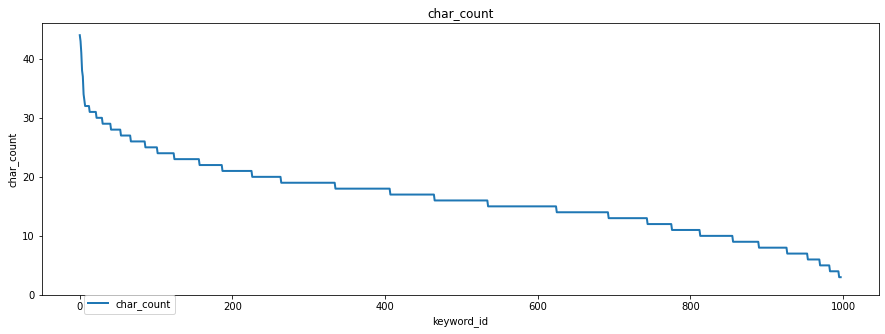

plot: histogram
feature: char_count
Freedman–Diaconis number of bins: 26


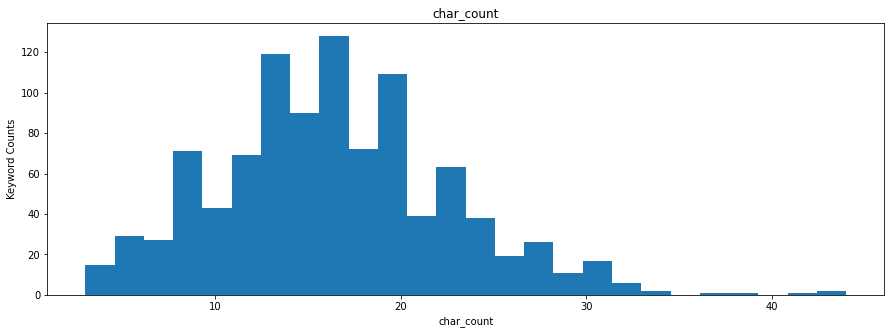

plot: line
feature: word_count


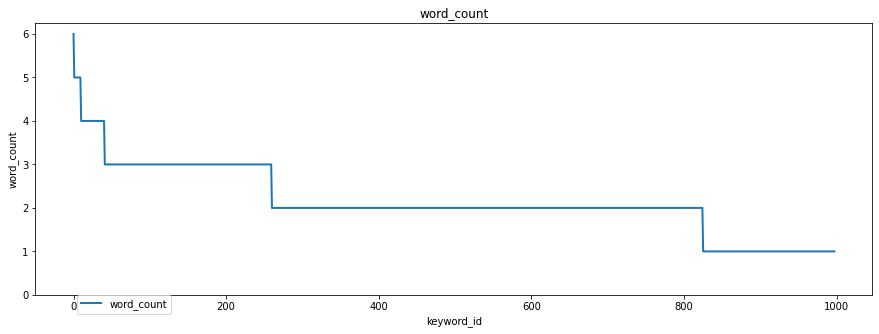

plot: histogram
feature: word_count
Freedman–Diaconis number of bins: 25


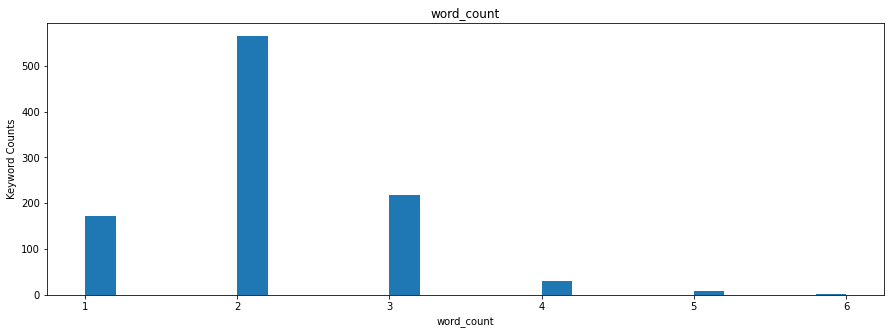

plot: line
feature: sent_count


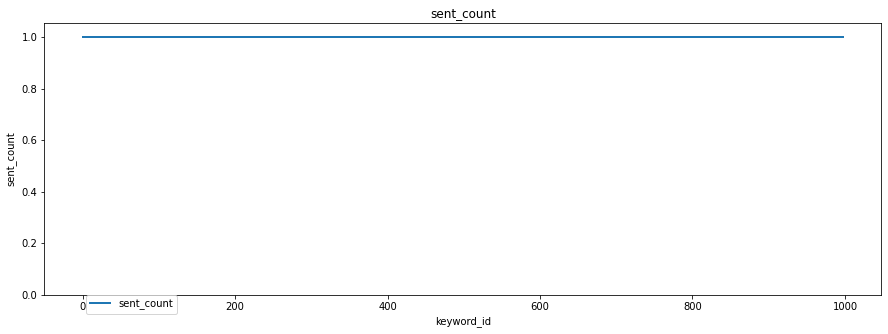

plot: histogram
feature: sent_count
Bins: 10


/var/folders/v8/5sm643_x35lbz1zwllwxvq4r0000gn/T/ipykernel_75058/672890327.py:66: RuntimeWarning: invalid value encountered in true_divide
  bins = round((plot_df['{0}'.format(feature)].max() - plot_df['{0}'.format(feature)].min()) / bin_width)


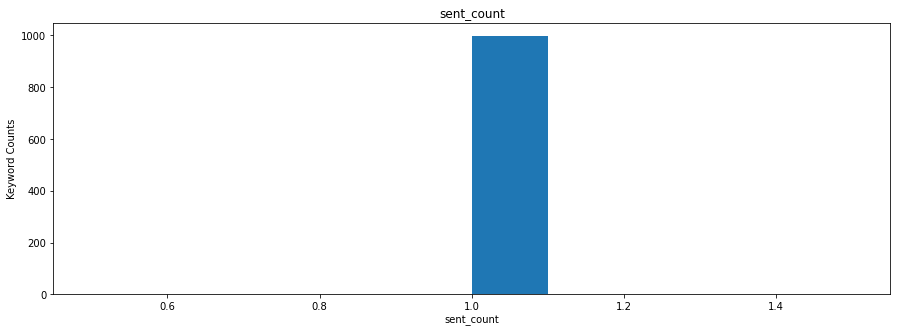

plot: line
feature: avg_word_len


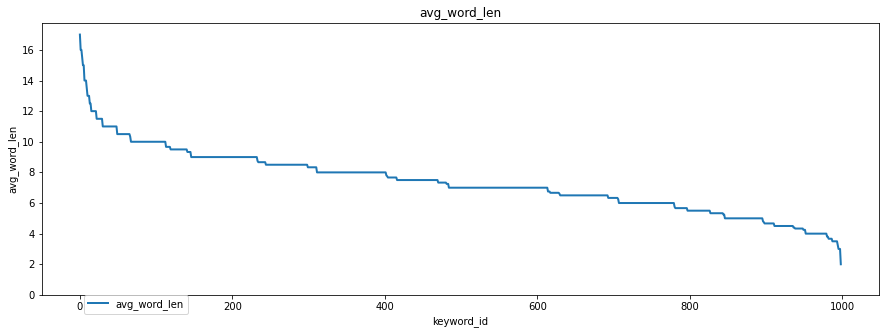

plot: histogram
feature: avg_word_len
Freedman–Diaconis number of bins: 30


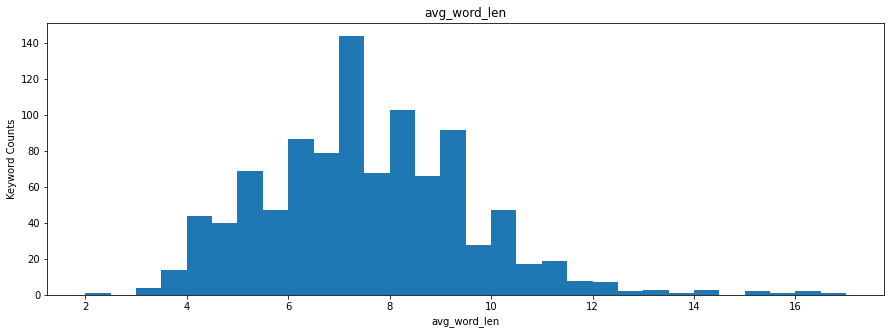

plot: line
feature: avg_sent_len


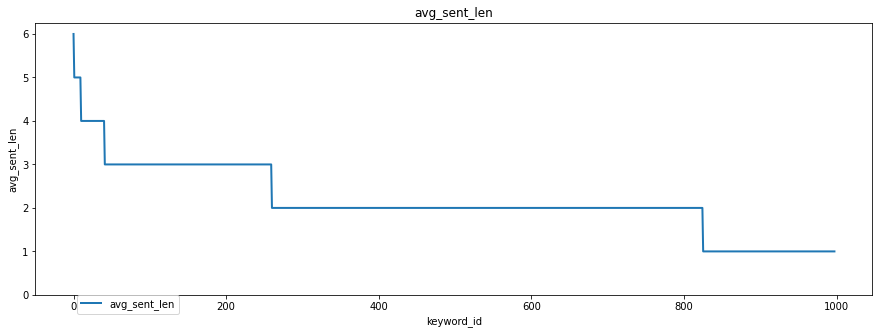

plot: histogram
feature: avg_sent_len
Freedman–Diaconis number of bins: 25


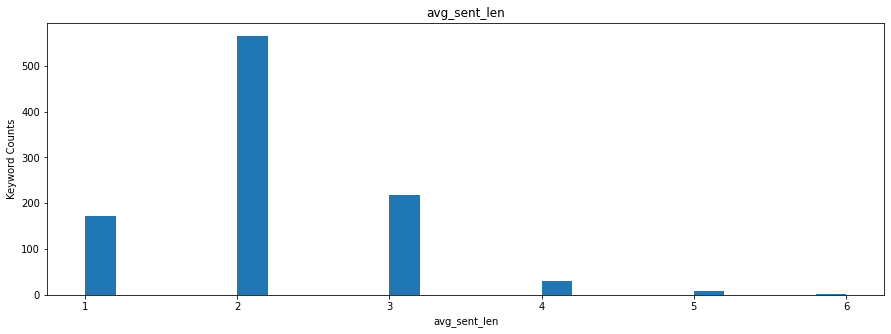

In [10]:
for feature in feature_list:
    for plot in plots:
        if plot == 'line':
            avg_value = data_df['{0}'.format(feature)].mean()
            # print(avg_value)
            max_value = avg_value * 3 # arbitrarily chose 3
            # print(max_value)
            plot_df = data_df
            plot_df = plot_df[plot_df['{0}'.format(feature)] < max_value]  
            # print(plot_df.head())
            print('plot: {0}'.format(plot))
            print('feature: {0}'.format(feature))
            plot_df = plot_df.sort_values(by='{0}'.format(feature), ascending=False).reset_index(drop=True)
            plot_df['keyword_id'] = plot_df.index
            plot_df = plot_df[['keyword_id','{0}'.format(feature)]]
            # print(plot_df.head())
            ## Resize Plot:
            plt.rcParams['figure.figsize'] = [15, 5] 

            ## Plot Settings
            axis = plt.gca() # gca = get current axis

            ## Series in Plot - Axis:
            plot_df.plot(kind='line', 
                    x='keyword_id', 
                    y='{0}'.format(feature),
                    linewidth = 2,
                    ax = axis)

            ## Set Plot Legend:
            axis.legend(bbox_to_anchor=(0.05, 0), loc='upper left', borderaxespad=0.)
            ## Disable Scientific Notation:
            axis.ticklabel_format(style='plain', axis='y')
            ## Title of Plot:
            plt.title('{0}'.format(feature))
            ## Y Axis Labels:
            axis.set_ylabel('{0}'.format(feature))
            # axis.set_xticklabels([]) # Remove X Axis Labels
            ## Set Cumulative Impact Axis Set "0" at Middle (for Axix2):
            yabs_max = abs(max(axis.get_ylim(), key=abs))
            axis.set_ylim(ymin=0) # Sets Y Minimum value
            ## Display Plot:
            plt.show()
        elif plot == 'histogram':
            avg_value = data_df['{0}'.format(feature)].mean()
            # print(avg_value)
            max_value = avg_value * 3 # arbitrarily chose 3
            # print(max_value)
            plot_df = data_df
            plot_df = plot_df[plot_df['{0}'.format(feature)] < max_value]  
            # print(plot_df.head())
            print('plot: {0}'.format(plot))
            print('feature: {0}'.format(feature))
            plot_df = plot_df.sort_values(by='{0}'.format(feature), ascending=False).reset_index(drop=True)
            plot_df['keyword_id'] = plot_df.index
            plot_df = plot_df[['keyword_id','{0}'.format(feature)]]
            # print(plot_df.head())
            ## Resize Plot:
            plt.rcParams['figure.figsize'] = [15, 5] 
            ## Plot Settings
            axis = plt.gca() # gca = get current axis
            
            try:
                q25, q75 = np.percentile(plot_df['{0}'.format(feature)], [25, 75])
                bin_width = 2 * (q75 - q25) * len(plot_df['{0}'.format(feature)]) ** (-1/3)
                bins = round((plot_df['{0}'.format(feature)].max() - plot_df['{0}'.format(feature)].min()) / bin_width)
                print('Freedman–Diaconis number of bins:', bins)
            except:
                bins = 10
                print('Bins:', bins)
            
            
            plt.hist(plot_df['{0}'.format(feature)], bins=bins)
            ## Set Plot Legend:
            # axis.legend(bbox_to_anchor=(0.05, 0), loc='upper left', borderaxespad=0.)
            ## Disable Scientific Notation:
            axis.ticklabel_format(style='plain', axis='y')
            ## Title of Plot:
            plt.title('{0}'.format(feature))
            ## Y Axis Labels:
            axis.set_ylabel('Keyword Counts')
            axis.set_xlabel('{0}'.format(feature))
            # axis.set_xticklabels([]) # Remove X Axis Labels
            ## Set Cumulative Impact Axis Set "0" at Middle (for Axix2):
            yabs_max = abs(max(axis.get_ylim(), key=abs))
            axis.set_ylim(ymin=0) # Sets Y Minimum value
            ## Display Plot:
            plt.show()
        else:
            print('none')

In [11]:
###########################################
# text = ' '.join(keyword_list)
text = ' '.join(keyword_list)
###########################################
text = text.lower() ## Lowercase Characters
text = contractions.fix(text) ## Expand Contractions ("don't" -> "do not")
text = text.translate(str.maketrans('', '', string.punctuation)) ## Remove Punctuation Characters
text = re.sub(r'(’)','', text) # Remove known characters
text = re.sub(r'[0-9]+', '', text) ## Remove Numerical Characters
text = unidecode.unidecode(text) ## Normalized accented characters (ñ -> n)
###########################################
text = word_tokenize(text) ## Tokenize Text
# stop_words = set(stopwords.words('english')) ## Get Stop Words
# # stop_words_exclusion = ['no','not','nor'] ## Stop Word Exclusion List
# # stop_words = [word for word in stop_words if word not in stop_words_exclusion] ## Remove Stop Word Exclusions from Stop Words
# # text = [word for word in text if word not in stop_words] ## Remove Stop Words
###########################################
wnl = WordNetLemmatizer() ## Lemmatization: 'studies' -> 'study'; 'studying' -> 'studying'
text = [wnl.lemmatize(word) for word in text] ## Apply Word Lemmatization
# print(text)

In [12]:
common_tokens_df = pd.DataFrame(text, columns=['word'])
common_tokens_df.head()
common_tokens_df['count'] = 1
common_tokens_df = common_tokens_df.groupby(['word'])['count'].count().reset_index()
common_tokens_df['% count'] = (common_tokens_df['count'] / common_tokens_df['count'].sum()) * 100
common_tokens_df.sort_values(by='count', ascending=False).head()

,word,count,% count
586,position,60,2.804
22,acid,52,2.430
337,gas,41,1.916
316,flow,31,1.449
500,multiple,28,1.308


In [17]:
n = 200
topn_df = data_df[:n]
remainder_df = data_df[n:]
topn_searches = topn_df['searches'].sum()
remainder_searches = remainder_df['searches'].sum()
topn_searches_perc_total = (topn_searches / (topn_searches + remainder_searches)) * 100

In [18]:
print('{0}% of Searches go to the Top {1} Keywords'.format(topn_searches_perc_total, n))

68.87896141065688% of Searches go to the Top 200 Keywords


In [20]:
topn_df = topn_df[['keyword']].head(n)
# topn_df.info()
topn_df.head()

,keyword
0,abatement of pollution
1,act of abating
2,active catalyst
3,eliminating process
4,forest region


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer
stop_words = set(stopwords.words('english')) ## Get Stop Words
vec = CountVectorizer(stop_words = stop_words, ngram_range = (2, 2)) ## ngram_range = (2, 2) only considers bi-grams, ngram_range = (3, 3) only considers tri-grams, and ngram_range = (2, 3) considers bi-grams and tri-grams
# Matrix of ngrams
bow = vec.fit_transform(topn_df['keyword'])
# Count frequency of ngrams
count_values = bow.toarray().sum(axis=0)
# Create DataFrame from ngram frequencies
ngram2_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram2_freq.columns = ['frequency', 'ngram']
ngram2_freq = ngram2_freq[['ngram','frequency']]

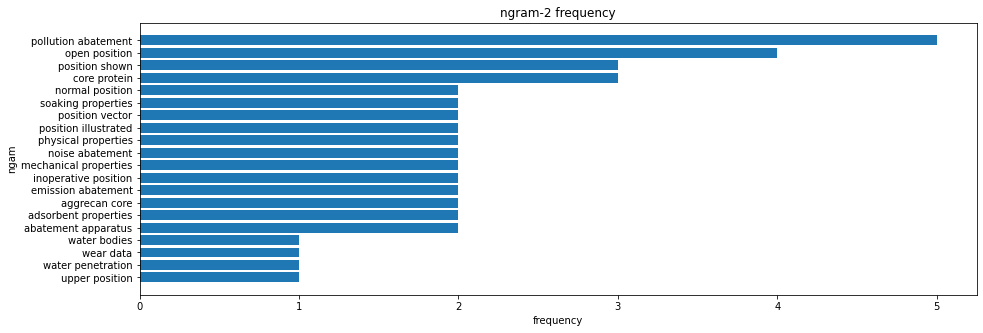

In [22]:
# ngram2_freq.head(20)
ngram2_freq_plot = ngram2_freq.head(20)
ngram2_freq_plot = ngram2_freq_plot.sort_values(by='frequency', ascending=True)
## Resize Plot:
plt.rcParams['figure.figsize'] = [15, 5] 
plt.barh(ngram2_freq_plot['ngram'], ngram2_freq_plot['frequency'])
plt.title('ngram-2 frequency')
plt.ylabel('ngam')
plt.xlabel('frequency')
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer
stop_words = set(stopwords.words('english')) ## Get Stop Words
vec = CountVectorizer(stop_words = stop_words, ngram_range = (3, 3)) ## ngram_range = (2, 2) only considers bi-grams, ngram_range = (3, 3) only considers tri-grams, and ngram_range = (2, 3) considers bi-grams and tri-grams
# Matrix of ngrams
bow = vec.fit_transform(topn_df['keyword'])
# Count frequency of ngrams
count_values = bow.toarray().sum(axis=0)
# Create DataFrame from ngram frequencies
ngram3_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram3_freq.columns = ['frequency', 'ngram']
ngram3_freq = ngram3_freq[['ngram','frequency']]

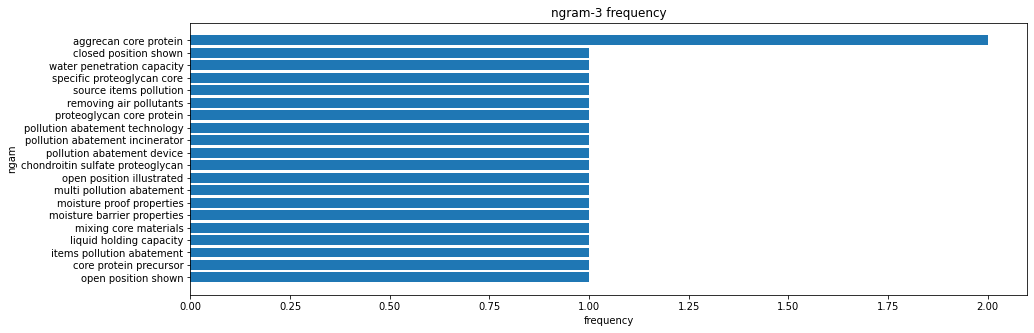

In [24]:
ngram3_freq_plot = ngram3_freq.head(20)
ngram3_freq_plot = ngram3_freq_plot.sort_values(by='frequency', ascending=True)
## Resize Plot:
plt.rcParams['figure.figsize'] = [15, 5] 
plt.barh(ngram3_freq_plot['ngram'], ngram3_freq_plot['frequency'])
plt.title('ngram-3 frequency')
plt.ylabel('ngam')
plt.xlabel('frequency')
plt.show()

In [25]:
pos_tokenized_words = nltk.pos_tag(text)
pos_df = pd.DataFrame(pos_tokenized_words, columns = ['word','pos tag'])
pos_abbreviation_dict = {
             'CC':'coordinating conjunction',
             'CD':'cardinal digit',
             'DT':'determiner',
             'EX':'existential there',
             'FW':'foreign word',
             'IN':'preposition/subordinating conjunction',
             'JJ':'adjective (large)',
             'JJR':'adjective, comparative (larger)',
             'JJS':'adjective, superlative (largest)',
             'LS':'list market',
             'MD':'modal (could, will)',
             'NN':'noun, singular (cat, tree)',
             'NNS':'noun plural (desks)',
             'NNP':'proper noun, singular (sarah)',
             'NNPS':'proper noun, plural (indians or americans)',
             'PDT':'predeterminer (all, both, half)',
             'POS':"possessive ending (parent's)",
             'PRP':'personal pronoun (hers, herself, him, himself)',
             'PRP$':'possessive pronoun (her, his, mine, my, our)',
             'RB':'adverb (occasionally, swiftly)',
             'RBR':'adverb, comparative (greater)',
             'RBS':'adverb, superlative (biggest)',
             'RP':'particle (about)',
             'TO':'infinite marker (to)',
             'UH':'interjection (goodbye)',
             'VB':'verb (ask)',
             'VBG':'verb gerund (judging)',
             'VBD':'verb past tense (pleaded)',
             'VBN':'verb past participle (reunified)',
             'VBP':'verb, present tense not 3rd person singular (wrap)',
             'VBZ':'verb, present tense with 3rd person singular (bases)',
             'WDT':'wh-determiner (that, what)',
             'WP':'wh- pronoun (who)',
             'WRB':'wh- adverb (how)'
            }
pos_df['pos tag meaning'] = pos_df['pos tag'].map(pos_abbreviation_dict)
# pos_df.head()

In [26]:
pos_df['count'] = 1
pos_df = pos_df.groupby(['word','pos tag','pos tag meaning'])['count'].count().reset_index()
# pos_df.sort_values(by='count', ascending=False).head()

In [27]:
pos_tag_df = pos_df.groupby(['pos tag meaning']).sum()
# pos_tag_df = pos_tag_df.reset_index()
pos_tag_df = pos_tag_df.sort_values(by='count', ascending=False)

Text(0, 0.5, 'count')

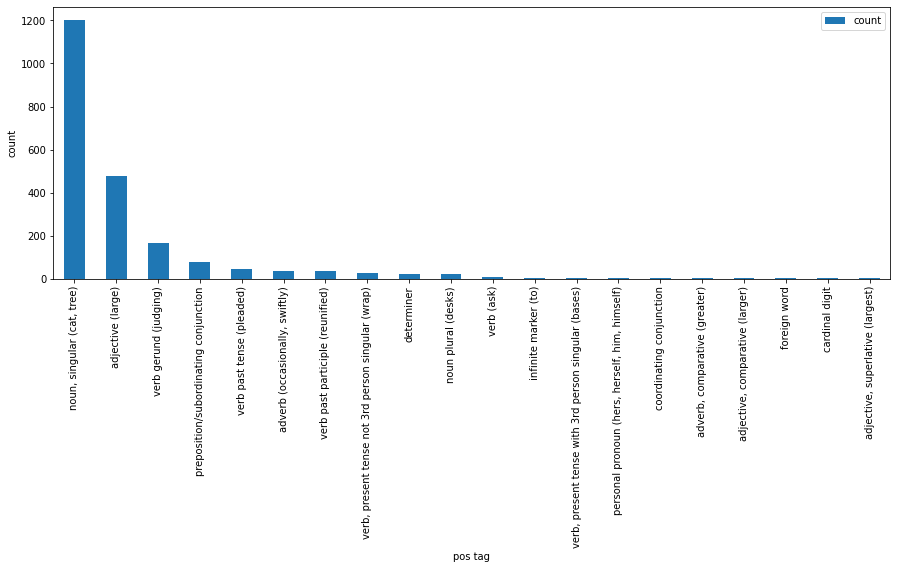

In [28]:
## Resize Plot:
plt.rcParams['figure.figsize'] = [15, 5] 
pos_tag_df.plot(kind='bar')
plt.xlabel('pos tag')
plt.ylabel('count')

noun, singular (cat, tree)


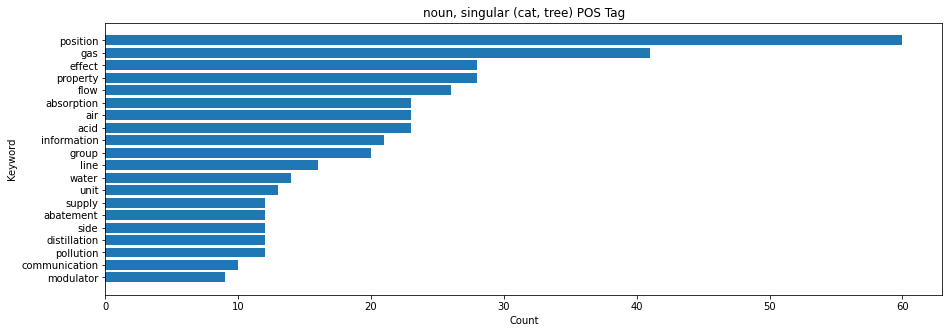

adjective (large)


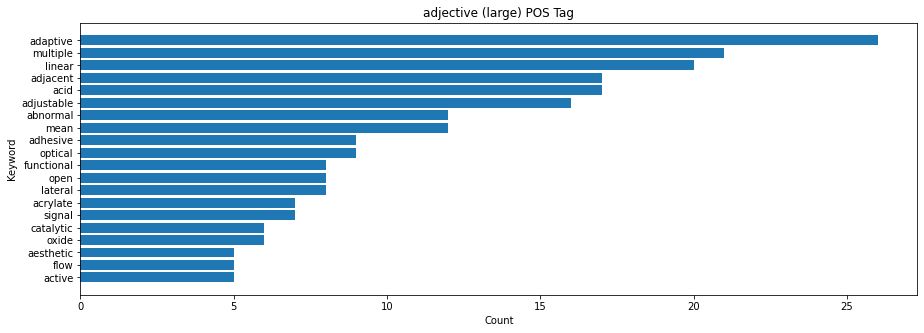

verb gerund (judging)


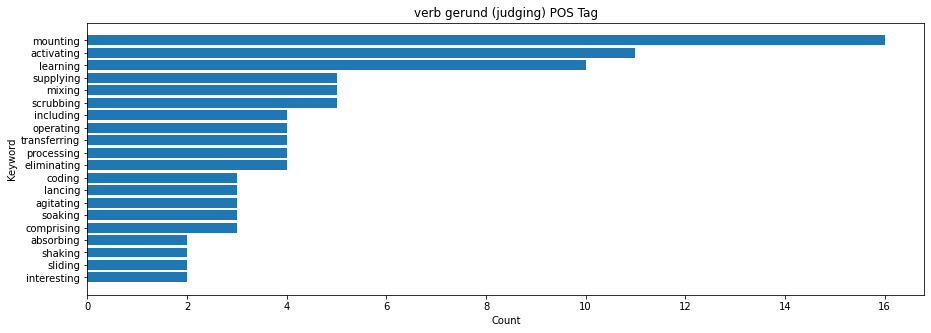

preposition/subordinating conjunction


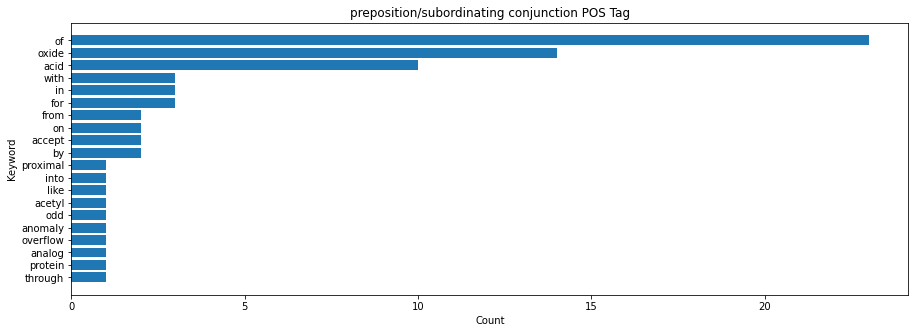

verb past tense (pleaded)


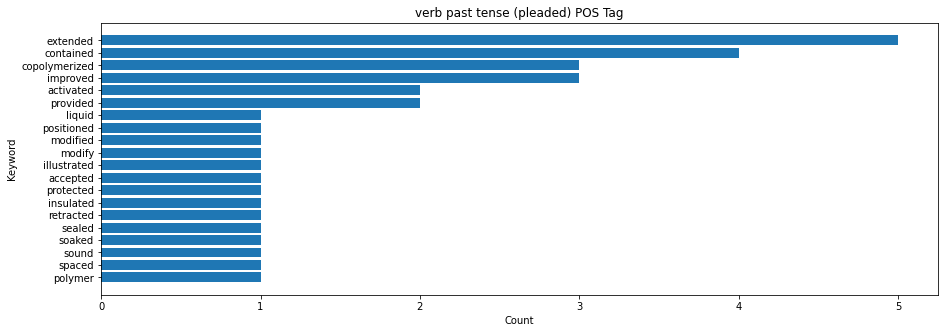

adverb (occasionally, swiftly)


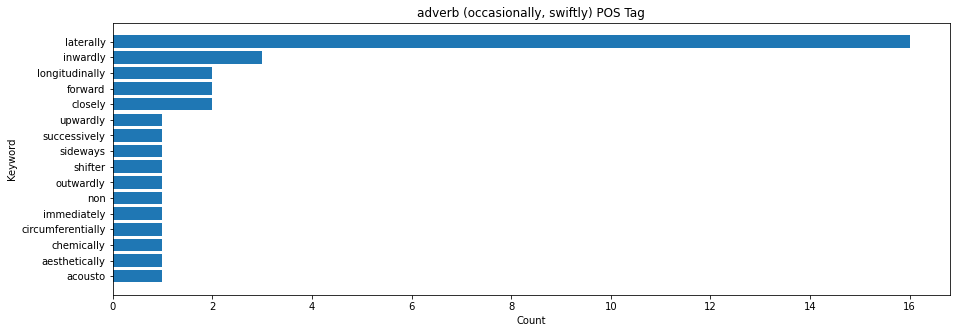

verb past participle (reunified)


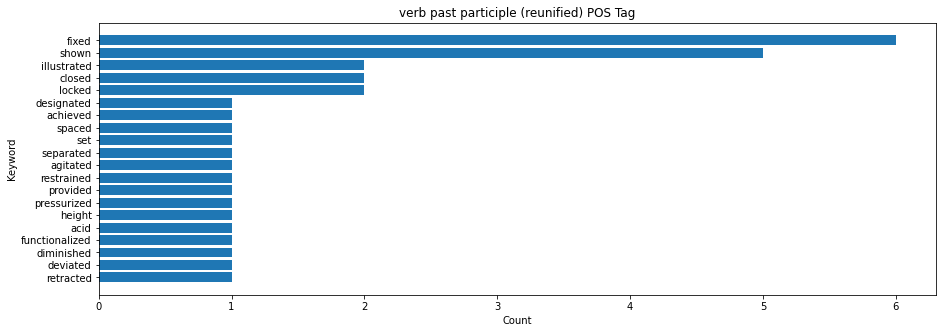

verb, present tense not 3rd person singular (wrap)


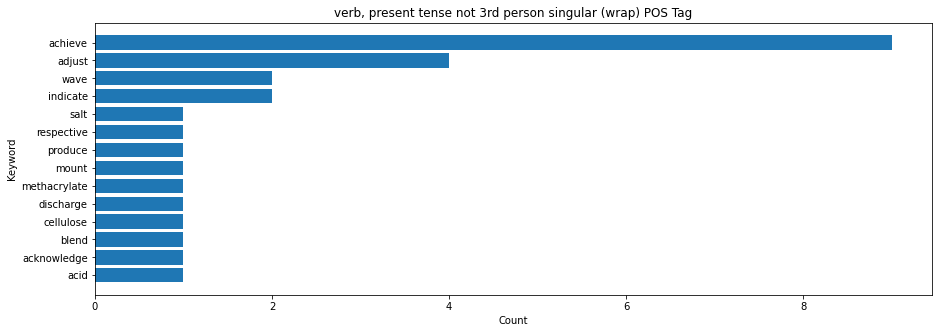

determiner


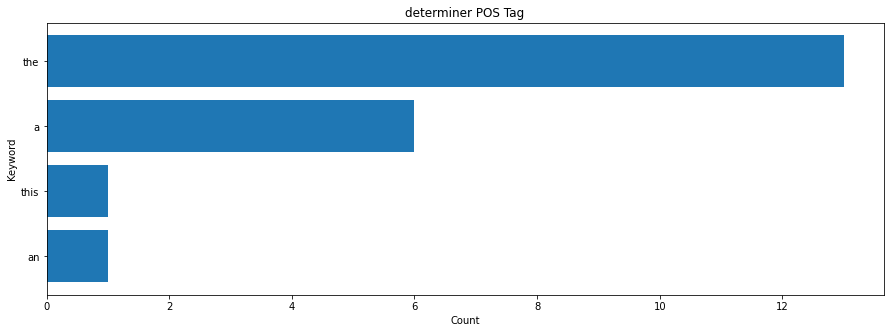

noun plural (desks)


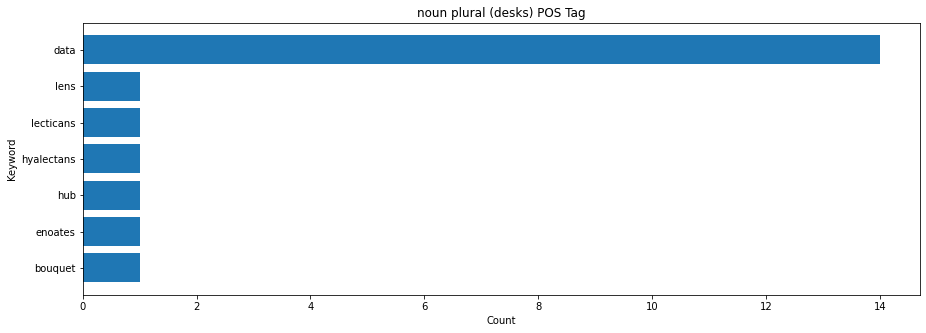

verb (ask)


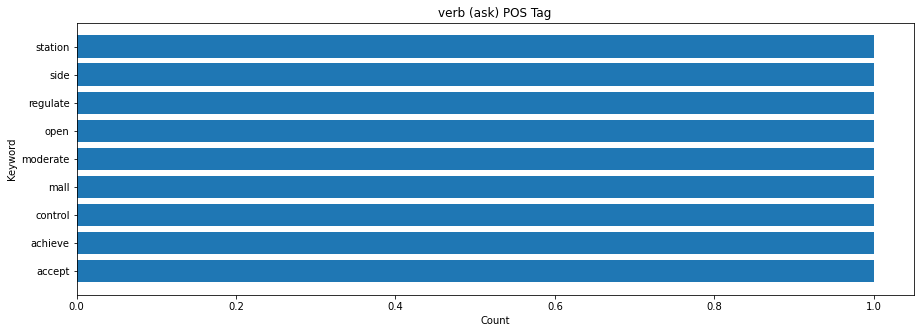

infinite marker (to)


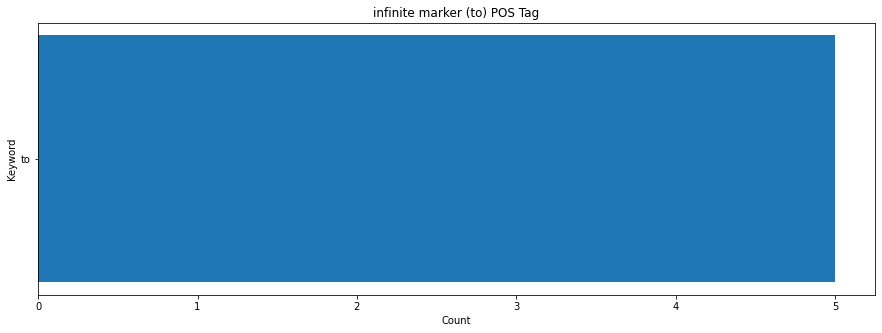

verb, present tense with 3rd person singular (bases)


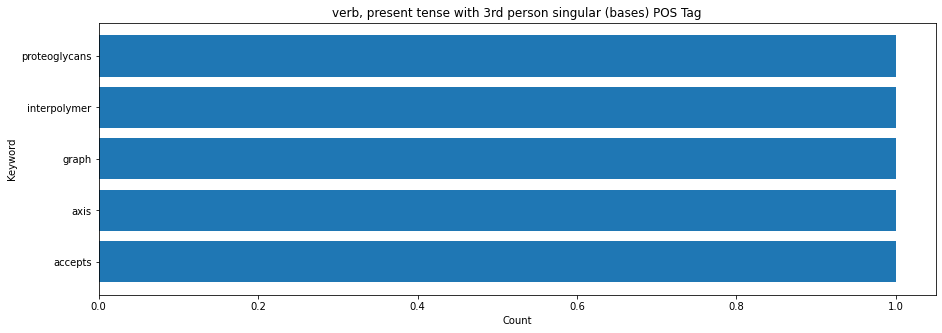

personal pronoun (hers, herself, him, himself)


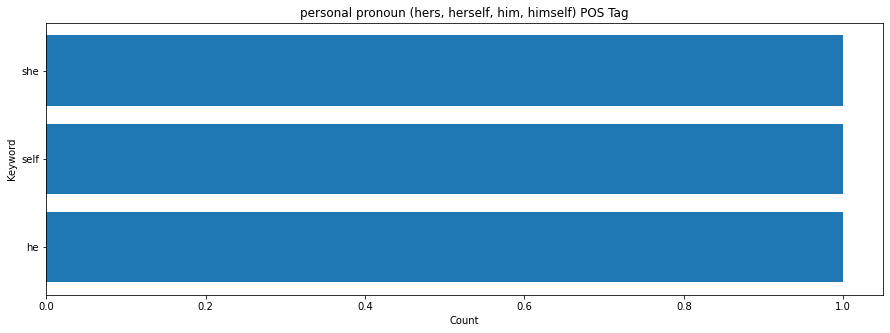

coordinating conjunction


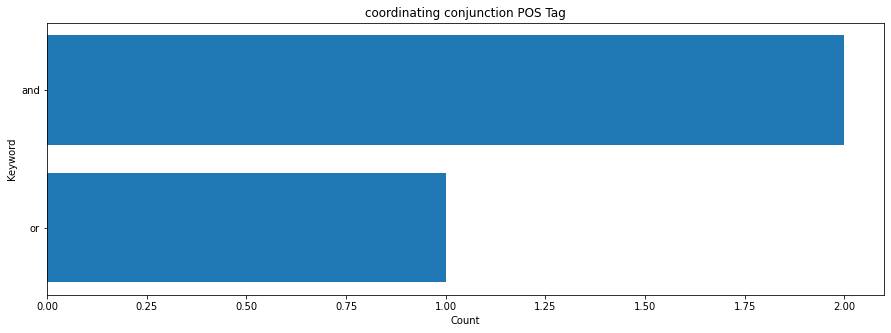

adverb, comparative (greater)


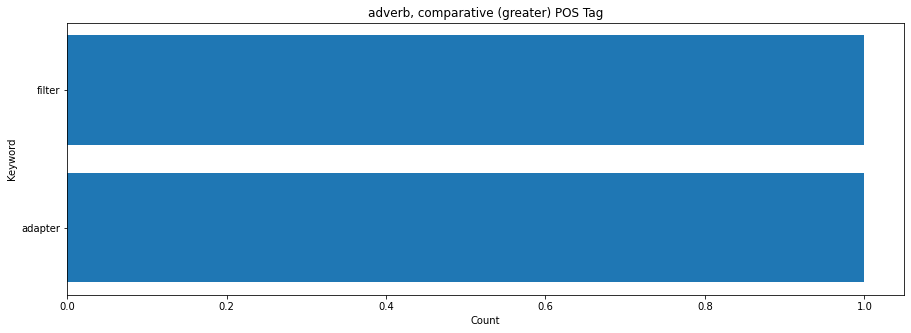

adjective, comparative (larger)


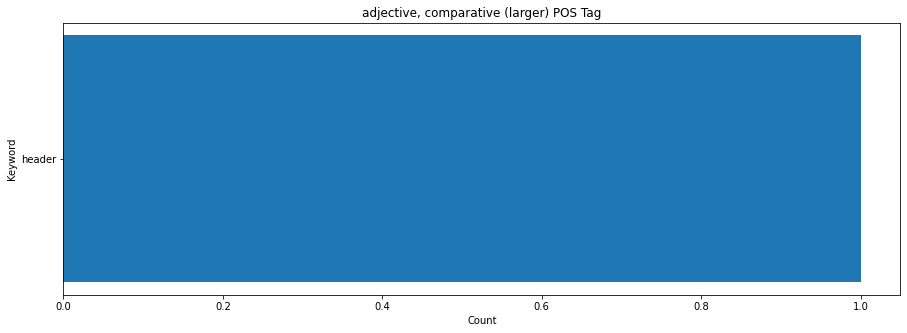

foreign word


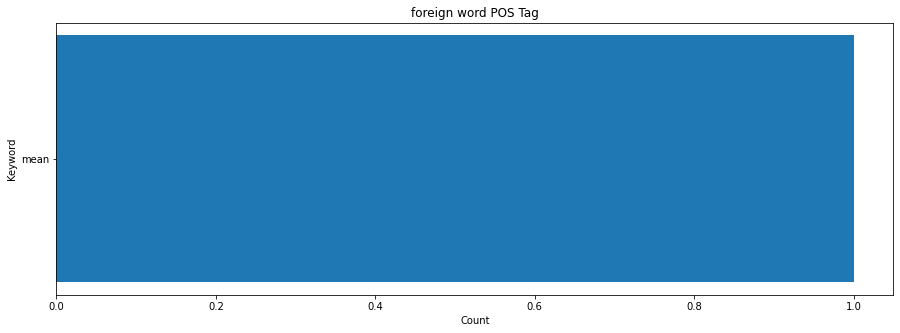

cardinal digit


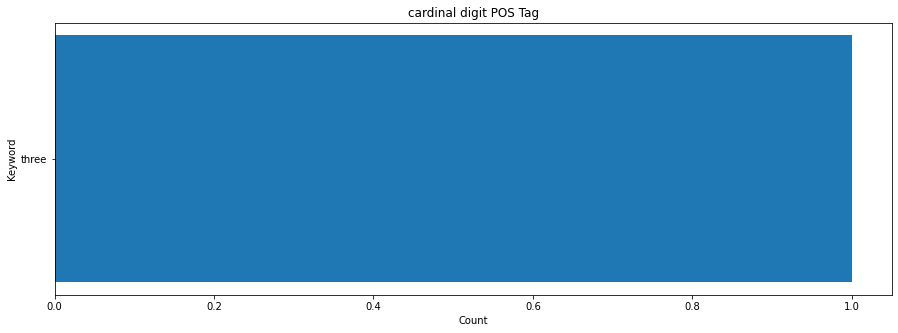

adjective, superlative (largest)


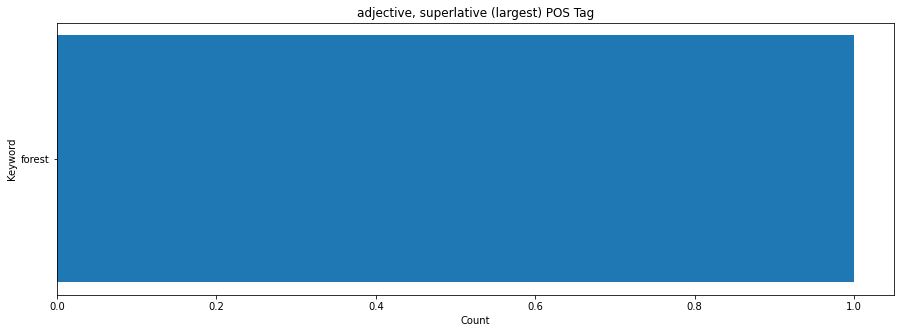

In [29]:
pos_tag_list = pos_tag_df.index.tolist()
for pos in pos_tag_list:
    print(pos)

    plot_df = pos_df.loc[pos_df['pos tag meaning'] == '{0}'.format(pos)].sort_values(by='count', ascending=False).head(20)
    plot_df = plot_df.sort_values(by='count', ascending=True)

    ## Resize Plot:
    plt.rcParams['figure.figsize'] = [15, 5] 
    plt.barh(plot_df['word'], plot_df['count'])
    plt.title('{0} POS Tag'.format(pos))
    plt.ylabel('Keyword')
    plt.xlabel('Count')
    plt.show()